# Pokemon Classification

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split


## 0. Data Preparation

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

# convert_img: This function loads an image, resizes it, and normalizes its pixels. This ensures that the image is prepared in a way that matches the preprocessing required for neural network inputs.
def convert_img(image_path, save_path=None, show=False):
    img = load_img(image_path, target_size=(227, 227))  # Load and resize the image
    img_array = img_to_array(img)  # Convert the image to an array
    img_normalized = img_array / 255.  # Normalize the image

    if save_path:  # Check if a save path is provided
        save_img(save_path, img_normalized)  # Save the normalized image

    if show:  # Check if the image is to be displayed
        plt.imshow(img_normalized)
        plt.title('Processed Image')
        plt.axis('off')
        plt.show()

    return img_normalized


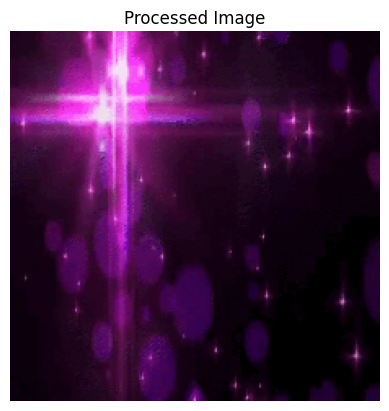

In [18]:
out=convert_img('example.gif', save_path='example.jpg', show=True)

In [19]:
type(out)

numpy.ndarray

In [20]:
def label_src(src_directory):
    data = []
    # Walk through all directories and files in the source directory
    for root, dirs, files in os.walk(src_directory):
        for file in files:
            if file.endswith((".jpg", ".png")):  # Check for .jpg or .png files
                path = os.path.join(root, file)  # Full path to the file
                label = os.path.basename(root)  # Directory name as label
                processed_image = convert_img(path)  # Process image
                data.append((processed_image, label))  # Append the tuple to the list
    return data

In [21]:
raw_data=label_src('src')

In [25]:
print(type(raw_data))
print(type(raw_data[0]))
print(type(raw_data[0][0]))
print(len(raw_data))

<class 'list'>
<class 'tuple'>
<class 'numpy.ndarray'>
9283


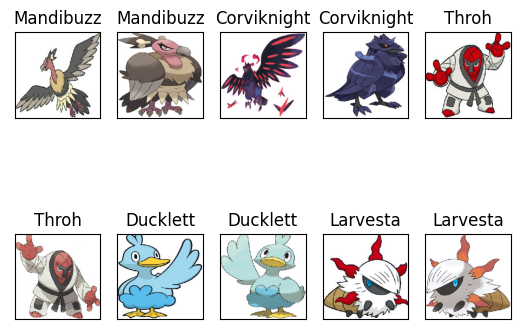

In [30]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(raw_data[i][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(raw_data[i][1])
plt.show()


## 1. Data Preprocessing

In [69]:
labels = []
for _, i in raw_data:
    if i not in labels: labels.append(i)
# for _, i in raw_data:
#     if i in labels: labels[i]+=1
#     else: labels[i]=1
#labels=sorted(list(labels.keys()))
labels.sort()
print(len(labels))
print(labels[:5])

inv_label={}
for i, label in enumerate(labels):
    inv_label[label]=i
# print(inv_label)

901
['Abomasnow', 'Abra', 'Absol', 'Accelgor', 'Aegislash']


In [79]:
trainval_set, test = train_test_split(raw_data, test_size=0.2, random_state=42)
train, valid = train_test_split(trainval_set, test_size=0.2, random_state=42)

x_train, y_train = np.array(list(map(lambda x: x[0], train))), np.array(list(map(lambda x: inv_label[x[1]], train)))
#print(x_train[0].shape, len(x_train)) # (227, 227, 3) 5940
x_test, y_test = np.array(list(map(lambda x: x[0], test))), np.array(list(map(lambda x: inv_label[x[1]], test)))
x_valid, y_valid = np.array(list(map(lambda x: x[0], valid))), np.array(list(map(lambda x: inv_label[x[1]], valid)))

In [81]:
print(f'x_train.shape: {x_train.shape},\ty_train.shape: {y_train.shape}')
print(f'x_test.shape: {x_test.shape},\ty_test.shape: {y_test.shape}')
print(f'x_valid.shape: {x_valid.shape},\ty_valid.shape: {y_valid.shape}')

x_train.shape: (5940, 227, 227, 3),	y_train.shape: (5940,)
x_test.shape: (1857, 227, 227, 3),	y_test.shape: (1857,)
x_valid.shape: (1486, 227, 227, 3),	y_valid.shape: (1486,)


## 2-1. Model1: Plain Convolution 2D Layer

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(227, 227, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # number of classes
])

In [87]:
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
hist = cnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
186/186 [==============================] - 128s 683ms/step - loss: 5.9722 - accuracy: 0.0131 - val_loss: 5.4152 - val_accuracy: 0.0242
Epoch 2/10
186/186 [==============================] - 120s 642ms/step - loss: 5.0287 - accuracy: 0.0700 - val_loss: 4.6844 - val_accuracy: 0.1144
Epoch 3/10
186/186 [==============================] - 126s 678ms/step - loss: 4.1940 - accuracy: 0.1852 - val_loss: 4.1320 - val_accuracy: 0.2039
Epoch 4/10
186/186 [==============================] - 122s 653ms/step - loss: 3.3328 - accuracy: 0.3145 - val_loss: 3.8494 - val_accuracy: 0.2840
Epoch 5/10
186/186 [==============================] - 126s 677ms/step - loss: 2.5372 - accuracy: 0.4503 - val_loss: 3.7974 - val_accuracy: 0.2981
Epoch 6/10
186/186 [==============================] - 121s 651ms/step - loss: 1.8682 - accuracy: 0.5771 - val_loss: 3.7647 - val_accuracy: 0.3230
Epoch 7/10
186/186 [==============================] - 122s 657ms/step - loss: 1.3611 - accuracy: 0.6707 - val_loss: 4.0570 -

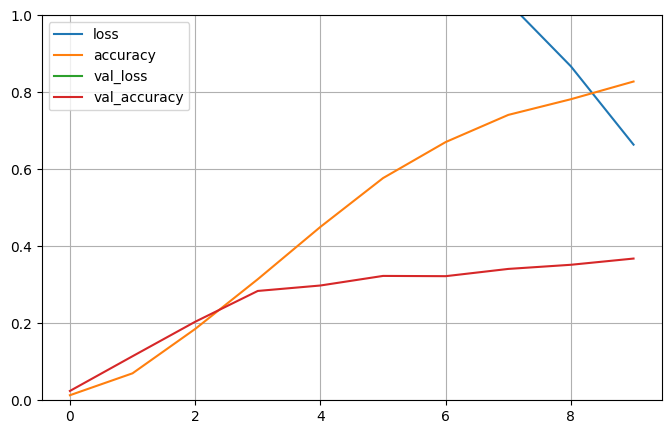

In [90]:
# Training Visualization

def visualize_hist(hist):
  pd.DataFrame(hist.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)

  plt.show()

visualize_hist(hist)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)


In [ ]:
model.save('pokemon_classifier_model.h5')


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('pokemon_classifier_model.h5')


In [ ]:
# Grading - test data로 진행한다고 한다!! (fixed)
# "Practicing the final project...!"

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2-2. Model2: Fine-tune from VGG-16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Randomly zooming inside pictures
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Assuming you have a directory structure with a subdirectory for each class
train_generator = train_datagen.flow_from_directory(
    'path_to_train_data',  # Path to training data
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

## 2. Model Loading

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create the model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(number_of_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


NameError: name 'number_of_classes' is not defined